# The notebook for feature_extracting and clustering

## Understand the dataset

In [61]:
import pandas as pd
df = pd.read_csv("dk_cookie",sep = ',',error_bad_lines = False)
print(df.head())
df = df[['domain_id','http_only','is_3p','name','secure','session','size','is_set_by_response']]

   id  page_id  domain_id         domain  expires_text  \
0   1        1          1    .google.com  1.619798e+09   
1   2        1          1    .google.com  1.633017e+09   
2   3        2        369     .google.dk  1.619798e+09   
3   4        2        369     .google.dk  1.633017e+09   
4   5        3         11  wikipedia.org  1.620039e+09   

               expires_timestamp http_only is_3p  is_1p_3p             name  \
0     2021-04-30 15:49:33.807+00         f     f       NaN           1P_JAR   
1  2021-09-30 15:49:33.492089+00         t     f       NaN              NID   
2  2021-04-30 15:49:34.076979+00         f     f       NaN           1P_JAR   
3   2021-09-30 15:49:33.75869+00         t     f       NaN              NID   
4  2021-05-03 10:48:18.527784+00         t     f       NaN  WMF-Last-Access   

  path same_site secure session  size  \
0    /      None      t       f    19   
1    /      None      t       f   178   
2    /      None      t       f    19   
3    /      

In [60]:
#  num of domain_id
df.groupby('domain_id').count()

,http_only,is_3p,name,secure,session,size,is_set_by_response
domain_id,,,,,,,
1,46,46,46,46,46,46,46
11,3,3,3,3,3,3,3
15,1,1,1,1,1,1,1
369,2,2,2,2,2,2,2
372,1,1,1,1,1,1,1
473,4,4,4,4,4,4,4
551,57,57,57,57,57,57,57
554,57,57,57,57,57,57,57
762,1,1,1,1,1,1,1


In [58]:
# domain_count
print(len(df['domain_id'].unique()))

# cookies num
print(len(df['name'].unique()))

1491
3453


## Preprocessing  the dataset

In [65]:
cookie_name_dump = pd.get_dummies(df['name'])
is_3p_dump = pd.get_dummies(df['is_3p'])
secure_dump = pd.get_dummies(df['secure'])
session_dump = pd.get_dummies(df['session'])
set_by_response_dump = pd.get_dummies(df['is_set_by_response'])

cookie_domain_set = pd.concat([df['size'],df['domain_id'],cookie_name_dump,is_3p_dump,secure_dump,session_dump,set_by_response_dump],axis = 1)

# del cookie_name_dump['name']
# del cookie_name_dump['is_3p']
# del cookie_name_dump['secure']
# del cookie_name_dump['session']
# del cookie_name_dump['is_set_by_response']

print(cookie_domain_set.head())

   size  domain_id  .ASPXANONYMOUS  .ASPXAUTH  \
0    19          1               0          0   
1   178          1               0          0   
2    19        369               0          0   
3   178        369               0          0   
4    26         11               0          0   

   .AspNetCore.Antiforgery.-SzxaGM9wQc  .AspNetCore.Antiforgery.qccZu4b6Ivc  \
0                                    0                                    0   
1                                    0                                    0   
2                                    0                                    0   
3                                    0                                    0   
4                                    0                                    0   

   .AspNetCore.GhostUserAuthentication  \
0                                    0   
1                                    0   
2                                    0   
3                                    0   
4                   

## normalization

In [71]:
from sklearn import preprocessing
cookie_values = cookie_domain_set.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(cookie_values)
cookie_scaled = pd.DataFrame(x_scaled,columns=cookie_domain_set.columns)
print(cookie_scaled.head())

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
       size  domain_id  .ASPXANONYMOUS  .ASPXAUTH  \
0  0.004237   0.000000             0.0        0.0   
1  0.043868   0.000000             0.0        0.0   
2  0.004237   0.000946             0.0        0.0   
3  0.043868   0.000946             0.0        0.0   
4  0.005982   0.000026             0.0        0.0   

   .AspNetCore.Antiforgery.-SzxaGM9wQc  .AspNetCore.Antiforgery.qccZu4b6Ivc  \
0                                  0.0                                  0.0   
1                                  0.0                                  0.0   
2                                  0.0                                  0.0   
3                                  0.0                                  0.0   
4                                  0.0                                  0.0  

### dimension reduction

In [72]:
from sklearn.decomposition import PCA

pca = PCA(2)
print(cookie_scaled.shape)
pca_data = pca.fit_transform(cookie_scaled)
print(pca_data.shape)

(16977, 3462)
(16977, 2)


## Modeling

In [75]:
from sklearn.cluster import KMeans

kmeans = KMeans(10)
kfit = kmeans.fit(pca_data)
identified_clusters = kfit.predict(pca_data)

print(identified_clusters)
print(len(identified_clusters))

[3 3 3 ... 9 9 9]
16977


## plot the picture

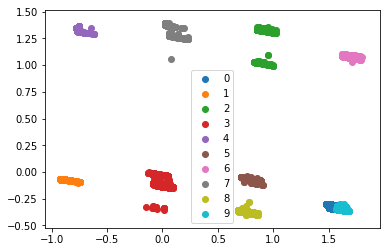

In [76]:
import matplotlib.pyplot as plt 
import numpy as np 
u_labels = np.unique(identified_clusters)

for i in u_labels:
    plt.scatter(pca_data[identified_clusters == i, 0],pca_data[identified_clusters == i, 1],label = i)
plt.legend()
plt.show()


## data view

In [80]:
clustered_data_scaled = df.copy()
clustered_data_scaled['Cluster'] = identified_clusters

df_sort = clustered_data_scaled.sort_values(by = 'Cluster')



       domain_id http_only is_3p                          name secure session  \
11828      62760         f     f            BI_UI_previousPage      f       f   
2118       73051         f     f                       _pubcid      f       f   
2119       73051         f     f                     cto_bidid      f       f   
2120       73051         f     f                    cto_bundle      f       f   
4877      131967         t     f                     sessionid      f       f   
2124       73051         f     f                        __gads      f       f   
4875      131914         f     f                _ga_FBP7C61M6Z      f       f   
4870        3950         f     f            outbrain_cid_fetch      f       f   
2117       73051         f     f     _pbjs_userid_consent_data      f       f   
4867      131914         f     f                   _biz_flagsA      f       f   
4856      131914         f     f                      _lc2_fpi      f       f   
4853      131914         f  